### Imports

In [ ]:
import os
import sys
import random

In [ ]:
import time

In [ ]:
import numpy as np

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
from torch import nn

In [ ]:
from torch.nn import functional

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
from torchvision.transforms import InterpolationMode

In [ ]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [ ]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [ ]:
from svetlanna.transforms import ToWavefront

In [ ]:
# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [ ]:
from tqdm import tqdm

In [ ]:
from datetime import datetime

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# 1. Simulation Parameters

## 1.1 Defining simulation parameters

In [ ]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]
working_wavelength = c_const / working_frequency  # [m]

# neuron size (square)
neuron_size = 0.53 * working_wavelength  # [m]

DETECTOR_SIZE = (128, 128)
# an actual zone where weights will be updated during a training process

# number of neurons in simulation
x_layer_nodes = DETECTOR_SIZE[1] * 1
y_layer_nodes = DETECTOR_SIZE[0] * 1
# Comment: Same size as proposed!

# physical size of each layer [cm]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size  # [m]

In [ ]:
print(f'lambda = {working_wavelength * 1e6:.3f} um')
print(f'neuron size = {neuron_size * 1e6:.3f} um')
print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')
print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

## 1.2 Creation of the grid(i.e. numerical mesh)

In [ ]:
# simulation parameters for the rest of the notebook
SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation (Data Engineer)

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset): loading and conversion to wavefronts

In [ ]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

### 2.1.1. Load Train and Test datasets of images

In [ ]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=False,
)

print(f'Train data: {len(mnist_train_ds)}')

In [ ]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=False,
)

print(f'Test data : {len(mnist_test_ds)}')

### 2.1.2. Detector

 `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

 Let's define the “Detector” object: 

### 2.1.3. Conversion images to wavefronts

# Optical Neural Network

In that example notebook we will try to realize a simple architecture of an optical neural network from an article [[1]](https://www.science.org/doi/10.1126/science.aat8084).

> In general, the phase and amplitude of eachneuron can be learnable parameters, providinga complex-valued modulation at each layer, which improves the inference performance of the diffractive network.

> ... we first trained it as a digit classifierto perform automated classification of hand-written digits, from $0$ to $9$. Forthis task, phase-only transmission masks were designed by training **a five-layer** $D^2 NN$ with $55,000$ images ($5000$ validation images) from the MNIST handwritten digit data-base.

>  We then used continuous-wave illumination at $0.4$ $THz$...

Some info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (information about MNIST classification):

> Because we consider coherent illumination, the input information can be encoded in the amplitude and/or phase channels of the input plane.

> For each layer of the $D^2NN$, we set we set the neuron size to be $400$ $\mu m$...

> At the detector/output plane, we measured the intensity of the network output...

#### <span style="color:red">Additional information</span>

In another article [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) of the same authors sume details were clarified: 

> In our numerical simulations, we used a neuron size of approximately $0.53 \times \lambda $

>  In addition, the height and width of each diffractive layer was set to include $200 \times 200 = 40K$ neurons per layer.

# 2. Dataset preparation (Data Engineer)

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [ ]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = './data'  # folder to store data

### 2.1.1. Load Train and Test datasets of images

In [ ]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=False,
)

In [ ]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=False,
)

In [ ]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Create Train and Test datasets of wavefronts

From [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> Input objects were encoded in amplitude channel (MNIST) of the input plane and were illuminated with a uniform plane wave at a wavelength of $\lambda$ to match the conditions introduced in [[1]](https://www.science.org/doi/10.1126/science.aat8084) for all-optical classification.

So, we need to do an amplitude modulation of each image from the dataset.

#### Select classes zones on `Detector`

> ... size of these detectors $(6.4 \lambda \times 6.4 \lambda)$ ...

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [ ]:
import src.detector_segmentation as detector_segmentation

In [ ]:
number_of_classes = 10

#### Detector mask

In [ ]:
detector_segment_size = 4 * working_wavelength

In [ ]:
# size of each segment in neurons
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# each segment of size = (y_segment_nodes, x_segment_nodes)

In [ ]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

In [ ]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # size of a detector or an aperture (in the middle of detector)
    SIM_PARAMS
)

**<span style="color:red">Comment:</span>** This mask will be used to generate a target image for each number! 

<span style="color:red">Target image:</span> zeros are everywhere except the necessary zone responsible for the label! 

#### To visualize detector zones (for further use)

In [ ]:
ZONES_HIGHLIGHT_COLOR = 'r'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_MASK.clone().detach()

In [ ]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 1 #0.5

    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)

        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta),
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
            linewidth=ZONES_LW,
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )

        zones_patches.append(zone_rect)

    return zones_patches

#### Visualize mask

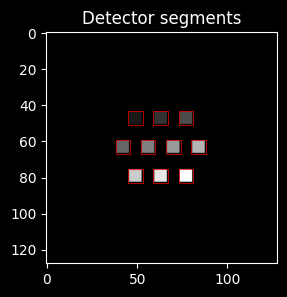

In [ ]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(selected_detector_mask, cmap='grey')

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax0.add_patch(zone)

plt.show()

#### Dataset of wavefronts

In [ ]:
# select modulation type
MODULATION_TYPE = 'amp'  # using ONLY amplitude to encode each picture in a Wavefront!

In [ ]:
resize_y = int(DETECTOR_SIZE[0] / 3)
resize_x = int(DETECTOR_SIZE[1] / 3)  # shape for transforms.Resize
# Comment: Looks like in [2] article MNIST pictures were resized to ~100 x 100 neurons

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [ ]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]
)

**<span style="color:red">Comment.</span>** Here `dataset.getitem()` will return a pair of a `Wavefront`, where a number encoded, and a target label (a number from 0 to 9). During the training process we will use MSE loss and we will generate a target detector picture based on a detector zones (will be initialized later in 3.1.3). 

In [ ]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [ ]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [ ]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


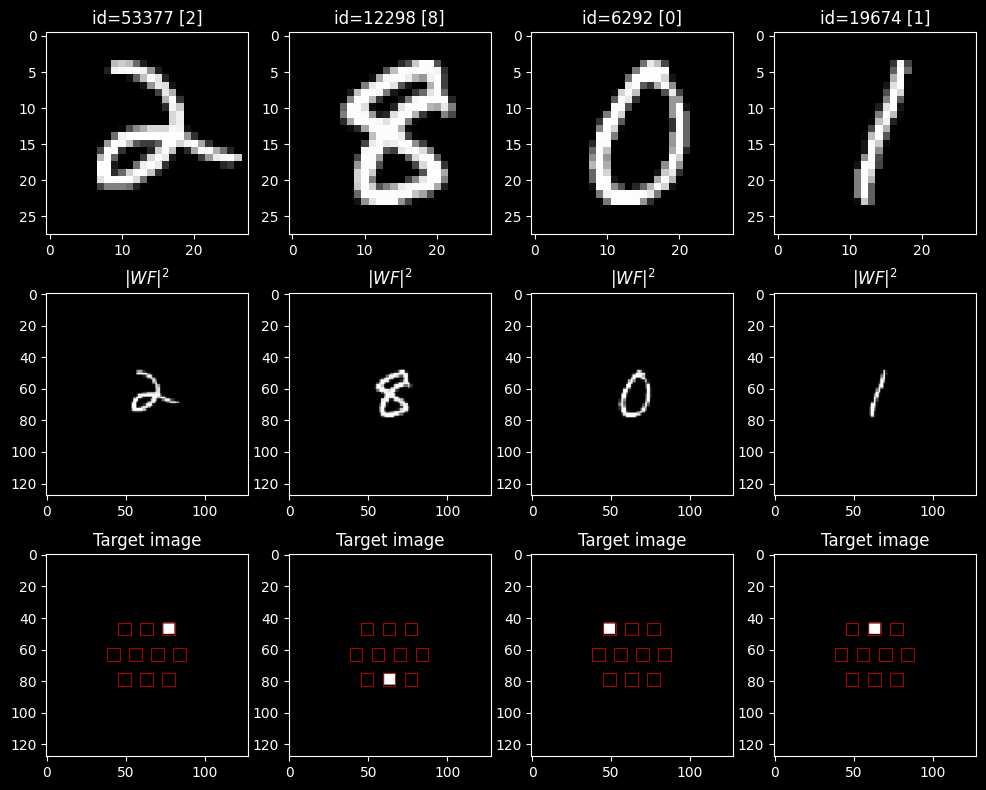

In [ ]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]

    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, target_image = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    # axs[2][ind_ex].set_title(f'phase of $WF$')
    # axs[2][ind_ex].imshow(
    #     wavefront.phase[0], cmap='gray',
    #     vmin=0, vmax= 2 * torch.pi
    # )

    axs[2][ind_ex].set_title(f'Target image')
    axs[2][ind_ex].imshow(
        target_image, cmap='gray',
        vmin=0, vmax= 1
    )

    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        axs[2][ind_ex].add_patch(zone)

plt.show()

# 3. Optical network

Info from a supplementary material of [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> Following the corresponding $D^2NN$ design, the axial distance between two successive 3D-printed layers was set to be $3.0$ $cm$...

> The distance between detector/output plane and the last layer of the optical neural network was adjusted as $3$ $cm$...

#### <span style="color:red">Additional information</span>

From [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):

> ... the axial distance between the successive diffractive layers is set to be $\sim 40 \times \lambda$ as in [[1]](https://www.science.org/doi/10.1126/science.aat8084) ...

**<span style="color:red">Difference.</span>** You can use an another number of diffractive layers (for phase-only training)!

In [ ]:
NUM_OF_DIFF_LAYERS = 5  # number of diffractive layers
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - distance between difractive layers

In [ ]:
print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


## 3.1. Architecture

See Figure 2A from [[1]](https://www.science.org/doi/10.1126/science.aat8084).

See Figure 1(a) from [[2]](https://ieeexplore.ieee.org/abstract/document/8732486).

### 3.1.1. List of Elements

In [ ]:
MAX_PHASE = 2 * np.pi  # max phase for phase masks

**<span style="color:red">Information from [1,2]: </span>**
> a $5$-layer, phase-only (complex-valued) diffractive optical network ...

**<span style="color:red">Difference.</span>** An another method for `FreeSpace`'s in contrast to [2]!

In [ ]:
FREESPACE_METHOD = 'AS'  # we use another method in contrast to [2]!!!

**<span style="color:red">Information from [2]: </span>**
> a diffractive layer ... neurons ... were initialized with $\pi$ for phase values and $1$ for amplitude values ...

In [ ]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi  # initial values for phase masks

**<span style="color:red">Comment</span>**

Here we are using a default `ConstrainedParameter` which is using the sigmoid function to limit a parameter range.

In [[2]](https://ieeexplore.ieee.org/abstract/document/8732486) authors discuss such approach in the section Results and Discussion A. and underline that limiting parameters with the sigmoid function may lead to Vanishing Gradients. Authors also propose an another way to limit parameters - by using ReLU.

In our case the sigmoid function works well but it is possible to realize the ReLU approach via specifying `bound_func` for `Constrained Parameter` (<span style="color:red">examples of customizing `bound_func` are provided in ...</span>).

In [ ]:
# functions that return single elements for further architecture

def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value

    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!

In [ ]:
def get_const_phase_layer_no_train(
    sim_params: SimulationParameters,
    value
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value

    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=const_mask,  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!

Function to construct a list of elements to reproduce an architecture from [the extended article](https://ieeexplore.ieee.org/abstract/document/8732486):

In [ ]:
def get_elements_list(
    num_layers,
    num_layers_no_train,
    simulation_parameters,
    freespace_method,
    phase_values,
):
    """
    Composes a list of elements for the setup.
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    phase_values : torch.Tensor()
        Torch tensor of phase values to generate constant masks for diffractive layers.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements

    # first FreeSpace layer before first DiffractiveLayer
    elements_list.append(
        get_free_space(
            simulation_parameters,  # simulation parameters for the notebook
            FREE_SPACE_DISTANCE,  # in [m]
            freespace_method=freespace_method,
        )
    )

    # compose the architecture
    for ind_layer in range(num_layers):

        # -----------------------------------------------------------------------
        # add DiffractiveLayer (learnable phase mask)
        elements_list.append(
            get_const_phase_layer(
                simulation_parameters,  # simulation parameters for the notebook
                value=phase_values[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # -----------------------------------------------------------------------

        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )
    # print(1111111111111111111111)
    for ind_layer in range(num_layers_no_train):

        # -----------------------------------------------------------------------
        # add DiffractiveLayer (untrained phase mask)
        elements_list.append(
            get_const_phase_layer_no_train(
                simulation_parameters,  # simulation parameters for the notebook
                value=phase_values[(ind_layer % (num_layers))].item()
            )
        )
        # -----------------------------------------------------------------------

        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )

    # ---------------------------------------------------------------------------
    # add Detector in the end of the system!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

In [ ]:
NUM_OF_DIFF_LAYERS_NO_TRAIN = 507

In [ ]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    num_layers_no_train=NUM_OF_DIFF_LAYERS_NO_TRAIN,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    phase_values=INIT_PHASES,
)

print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 1026


### 3.1.2. Compose `LinearOpticalSetup`

In [ ]:
def get_setup():
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        num_layers_no_train=NUM_OF_DIFF_LAYERS_NO_TRAIN,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        phase_values=INIT_PHASES,
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [ ]:
# creaye an optical setup
optical_setup = get_setup()

**<span style="color:red">Comment:</span>** Setup ends with `Detector` that returns an output tensor of intensities for each input `Wavefront`.

### 3.1.3 Detector processor (to calculate accuracies only)

> ... size of these detectors $(6.4 \lambda \times 6.4 \lambda)$ ...

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [ ]:
CALCULATE_ACCURACIES = True  # if False, accuracies will not be calculated!

In [ ]:
# create a DetectorProcessorOzcanClf object
if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=number_of_classes,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

# 4. Training of the network

Variables at the moment
- `lin_optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [ ]:
DEVICE = 'cuda'  # 'mps' is not support a CrossEntropyLoss


In [ ]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cuda'

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

Info from a supplementary material of [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> The training batch size was set to be $8$...

In [ ]:
train_bs = 128  # a batch size for training set
val_bs = 64

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [ ]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

In [ ]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Info from a supplementary material of [[1]](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

**<span style="color:red">Additional info</span>** from [[2]](https://ieeexplore.ieee.org/abstract/document/8732486):
> a back-propagation method by applying the adaptive moment estimation optimizer (Adam) with a learning rate of $10^{−3}$

In [ ]:
LR = 1e-3

In [ ]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

**<span style="color:red">Comment:</span>** We are using `MSELoss` as in [1] (that was clarified in [2])! 

In [ ]:
loss_func_clf = nn.MSELoss()  # by default: reduction='mean'
loss_func_name = 'MSE'

### 4.1.3. Training and evaluation loops

In [ ]:
def onn_train_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR needed for accuracies only!
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Function to train `optical_net` (classification task)
    ...

    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        optimizer: torch.optim
            Optimizer...
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.

    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.train()  # activate 'train' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()

        # forward of an optical network
        detector_output = optical_net(batch_wavefronts)

        # calculate loss for a batch
        loss = loss_func(detector_output, batch_targets)

        loss.backward()
        optimizer.step()

        # ACCURACY
        if CALCULATE_ACCURACIES:
            # process a detector image
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_output)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy

In [ ]:
def onn_validate_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR NEEDED!
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Function to validate `optical_net` (classification task)
    ...

    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.

    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.eval()  # activate 'eval' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            detector_outputs = optical_net(batch_wavefronts)
            # calculate loss for a batch
            loss = loss_func(detector_outputs, batch_targets)

        # ACCURACY
        if CALCULATE_ACCURACIES:
            # process a detector image
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_outputs)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy

## 4.2. Training of the optical network

### 4.2.1. Before training

> a diffractive layer ... neurons ... were initialized with $\pi$ for phase values and $1$ for amplitude values ...

#### Metrics for Test dataset

In [ ]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [ ]:
optical_setup.net = optical_setup.net.to(DEVICE)
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
detector_processor = detector_processor.to(DEVICE)

In [ ]:
# test_losses_0, _, test_accuracy_0 = onn_validate_mse(
#     optical_setup.net,  # optical network composed in 3.
#     test_wf_loader,  # dataloader of training set
#     detector_processor,  # detector processor
#     loss_func_clf,
#     device=DEVICE,
#     show_process=True,
# )  # evaluate the model

# print(
#     'Results before training on TEST set:\n' +
#     f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
#     f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
# )

### 4.2.2. Training

In [ ]:
n_epochs = 10
print_each = 2  # print each n'th epoch info

In [ ]:
scheduler = None  # sheduler for a lr tuning during training

In [ ]:
# Recreate a system to restart training!
ozcan_optical_setup = get_setup(SIM_PARAMS)

# Linc optimizer to a recreated net!
optimizer_clf = get_adam_optimizer(ozcan_optical_setup.net)

In [ ]:
ozcan_optical_setup.net = ozcan_optical_setup.net.to(DEVICE)

In [ ]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_mse(
        ozcan_optical_setup.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_mse(
        ozcan_optical_setup.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')

    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train:   0%|          | 2/430 [00:12<43:36,  6.11s/it]


KeyboardInterrupt: 

#### Learning curves (MSELoss and Accuracy)

In [ ]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), np.array(train_epochs_losses) * 1e3, label='train')
axs[0].plot(range(1, n_epochs + 1), np.array(val_epochs_losses) * 1e3, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name + r' $\times 10^3$')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [ ]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

#### Trained phase masks

In [ ]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

for ind_layer, layer in enumerate(ozcan_optical_setup.net.to(torch.device("cpu"))):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_diff_layer + 1}. DiffractiveLayer')

        trained_mask = layer.mask.detach()

        ax_this.imshow(
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.set_xlim([x_frame, x_layer_nodes - x_frame])
    ax_this.set_ylim([y_frame, y_layer_nodes - y_frame])

plt.show()

### 4.2.3. Saving the results

#### Pathes

In [ ]:
RESULTS_FOLDER = 'models/reproduced_results/MNIST_MSE_Ozcan_2018-2020_GPU'

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [ ]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net_gpu.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves_gpu.csv'

#### Saving model weights and learning curves

In [ ]:
# saving model
torch.save(ozcan_optical_setup.net.state_dict(), model_filepath)

In [ ]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

# 5. Load saved weights for the model

In [ ]:
RESULTS_FOLDER = 'models/reproduced_results/MNIST_MSE_Ozcan_2018-2020_gpu'

load_model_filepath = f'{RESULTS_FOLDER}/optical_setup_net_gpu.pth'

In [ ]:
# setup to load weights
ozcan_optical_setup_loaded = get_setup(SIM_PARAMS)

# LOAD WEIGHTS
ozcan_optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

## 5.1. Calculate metrics on test set for the loaded model

Checking if the loaded model works correctly!

In [ ]:
test_losses_1, _, test_accuracy_1 = onn_validate_mse(
    ozcan_optical_setup_loaded.net.to(torch.device("cuda")),  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' +
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

## 5.2. Example of classification (propagation through the setup)

### 5.2.1. Select a sample to propagate

In [ ]:
# plot an image
# '1' - 3214, good
# '4' - 6152, good
# '6' - 123, good
# '8' - 128, good
# '0' - 3, good
ind_test = 128
cmap = 'hot'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = mnist_wf_test_ds[ind_test]

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(test_wavefront.intensity, cmap=cmap)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase, cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [ ]:
# propagation of the example through the trained network
ozcan_optical_setup_loaded.net.to(torch.device("cpu"))
setup_scheme, test_wavefronts = ozcan_optical_setup_loaded.stepwise_forward(test_wavefront)

### 5.2.2. Amplitude profiles

In [ ]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(ozcan_optical_setup_loaded.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

within_aperture = True  # if true plots only the field which is within apertures!

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(test_wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    # delete unnecessary ticks
    if not (ind_wf // n_cols) == n_rows - 1:
        ax_this.set_xticks([])
    if not (ind_wf % n_cols) == 0:
        ax_this.set_yticks([])

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(test_wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )

    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!
    if within_aperture:
        # select only a part within apertures!
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

### 5.2.3. Detector picture

In [ ]:
# create a figure with subplots
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# Detector output (not a wavefront!)
ax_this.set_title('Detector Intensity')
ax_this.imshow(
    test_wavefronts[-1].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax_this.add_patch(zone)

# select only a part within apertures!
x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
plt.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

In [ ]:
# get probabilities of an example classification
if detector_processor:
    test_probas = detector_processor.forward(test_wavefronts[-1])
    # Comment: forward() method is from DetectorProcessorClf
    #          p_i = I(detector_i) / sum_j(I(detector_j))

    assert np.isclose(test_probas.sum().item(), 1)

    for label, prob in enumerate(test_probas[0]):
        print(f'{label} : {prob * 100:.2f}%')

## 5.3. Energy _efficiency_

### 5.3.1. Predict all Test dataset and save all results

In [ ]:
targets_test_lst = []
preds_test_lst = []

detector_sums_by_classes = [
    torch.zeros(size=SIM_PARAMS.axes_size(axs=('H', 'W'))) for _ in range(number_of_classes)
]
samples_by_classes = [0 for _ in range(number_of_classes)]
probas_sums_by_classes = [
    torch.zeros(number_of_classes) for _ in range(number_of_classes)
]

# loop over the test dataset
for ind, (wavefront_this, target_this) in enumerate(tqdm(mnist_wf_test_ds)):
    ozcan_optical_setup_loaded.net.eval()

    batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
    batch_targets = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches

    batch_labels = detector_processor.batch_forward(batch_targets).argmax(1)

    with torch.no_grad():
        detector_output = ozcan_optical_setup_loaded.net(batch_wavefronts)
        # process a detector image
        batch_probas = detector_processor.batch_forward(detector_output)

        for ind_in_batch in range(batch_labels.size()[0]):
            label_this = batch_labels[ind_in_batch].item()  # true label
            targets_test_lst.append(label_this)

            detector_sums_by_classes[label_this] += detector_output[ind_in_batch]
            probas_sums_by_classes[label_this] += batch_probas[ind_in_batch]
            samples_by_classes[label_this] += 1

            preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())

### 5.3.2. Confusion matrix

In [ ]:
for class_ind in range(number_of_classes):
    probas_sums_by_classes[class_ind] /= samples_by_classes[class_ind]

In [ ]:
avg_probas_mat = torch.zeros(size=(number_of_classes, number_of_classes))

for ind_class in range(number_of_classes):
    avg_probas_mat[ind_class, :] = probas_sums_by_classes[ind_class]

In [ ]:
# ordinary confusion matrix
confusion_matrix = torch.zeros(size=(number_of_classes, number_of_classes), dtype=torch.int32)

for ind in range(len(mnist_wf_test_ds)):
    confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1

#### Plot confusion matrices

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# CONFUSION MATRIX
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix, cmap='Blues')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = confusion_matrix[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center',
            c='k', fontsize=9
        )

ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(number_of_classes))
ax0.set_yticks(range(number_of_classes))

# AVERAGED PREDICTED PROBAS
ax1.set_title('Averaged confidences')
ax1.matshow(avg_probas_mat, cmap='Greens')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = avg_probas_mat[j, i].item()
        ax1.text(
            i, j, f'{val:.1f}',
            va='center', ha='center',
            c='k', fontsize=9
        )

ax1.set_xlabel(r'$\sum I_i / \left( \sum I_0 + \dots + \sum I_9 \right)$')

ax1.set_xticks(range(number_of_classes))
ax1.set_yticks(range(number_of_classes))
# ax1.set_yticks(range(number_of_classes), labels=['' for _ in range(number_of_classes)])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/confusion_matrix.png', bbox_inches='tight')

### 5.3.3. Averaged detector for a selected class

In [ ]:
n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (number_of_classes // n_cols)

detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= number_of_classes:
            ax_this.axis('off')

# plot wavefronts
for selected_class in range(number_of_classes):
    ax_this = axs[selected_class // n_cols][selected_class % n_cols]

    # focus "efficiency"
    int_over_detector_zones = 0

    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency = int_over_detector_zones / detector_int

    # Detector output (not a wavefront!)
    ax_this.set_title(
        f'`{selected_class}`: ' + r'$E_{zones}\approx$' +
        f'{detector_efficiency * 100:.2f} %'
    )
    ax_this.imshow(
        detector_sums_by_classes[selected_class] / samples_by_classes[selected_class],
        cmap=detector_cmap,
        # vmin=0, vmax=0.02  # uncomment to make the same limits
    )

    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        ax_this.add_patch(zone)

    ax_this.set_xticks([])
    ax_this.set_yticks([])

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/averaged_detector_for_classes.png', bbox_inches='tight')

### 5.6.3. Detector _efficiency_

$$
\frac{\sum\limits_{\text{class}=0}^9 \left( \iint\limits_{S_\text{class}} I(x,y) \right)}{\iint\limits_{S_\text{detector}} I(x,y)}
$$

In [ ]:
detector_efficiency_by_classes = {}

for selected_class in range(number_of_classes):
    int_over_detector_zones = 0

    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency_by_classes[selected_class] = int_over_detector_zones / detector_int

In [ ]:
detector_efficiency_by_classes